# BERTを用いた日本語ニュースの特徴量ベクトルの取得

#  Extracting fixed feature vectors of Japanese news by BERT

## 1. Import library　（ライブラリの取得）

In [0]:
import tensorflow as tf
import pandas as pd
import os
import re
import sys
import time
import numpy as np

from pathlib import Path
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
from tensorflow.keras import backend as K

In [3]:
!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
import modeling
import optimization
import tokenization
from tokenization import FullTokenizer

# import tfhub 
import tensorflow_hub as hub

# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1"
max_seq_length = 50



Cloning into 'bert_repo'...
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325
Receiving objects: 100% (325/325), 232.46 KiB | 3.10 MiB/s, done.
Resolving deltas: 100% (186/186), done.


W0528 13:13:36.675282 140326630848384 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


## 2. Load livedoor-news-data　（ライブドアニュースデータの取得）


livedoor news corpus    CC BY-ND 2.1 JP　　　https://www.rondhuit.com/download.html#ldcc

In [0]:
train_df = pd.read_csv("train5.tsv", delimiter='\t', header=None, names=['label', 'title'])
dev_df = pd.read_csv("dev5.tsv", delimiter='\t', header=None, names=['label', 'title'])

In [6]:
train_df=train_df.loc[:, ['title','label']]
train_df=train_df.rename({'title':'sentence','label':'polarity'},axis='columns')
train_df.head() 

,sentence,polarity
0,【Sports Watch】岡田監督、高校時代は女性用パンティーを着用!?,2
1,第24回東京国際映画祭作品ガイド＜ワールドシネマ部門＞,1
2,宮崎あおい、堺雅人、竹内結子ら美男美女が勢揃い ＜2011年インタビューまとめ vol.5＞,1
3,美女たちがドレスの競演をした東京国際映画祭！スケスケのシースルー衣装を着たセクシー女優も,1
4,クマのぬいぐるみが禁止用語連発！“可愛くて過激”な笑撃映像が話題,1


In [7]:
dev_df=dev_df.loc[:, ['title','label']]
dev_df=dev_df.rename({'title':'sentence','label':'polarity'},axis='columns')
dev_df.head(20) 

,sentence,polarity
0,制服姿の大政絢やナルニアの王子などにも直撃＜2011年インタビューまとめ vol.1＞,1
1,マイクロソフトが方針転換を始めた！マイクロソフトの独自タブレット【デジ通】,0
2,【Sports Watch】宇佐美、バイエルンミュンヘン移籍が決定的!? 「レギュラーとれな...,2
3,117万2132件の動画中最高の1本！ニコニコ動画「第4回動画アワード」グランプリ作品決定,0
4,デルからLEDバックライト付きフルHD液晶ディスプレイ発売に,4
5,現地メディア、錦織圭の快挙を賞賛,2
6,空前の子役ブームに衝撃？ 大橋のぞみ引退から見る子役の引き際とは【話題】,4
7,街のビデオ屋目線のTest Room,4
8,サムスンがアップルに逆転勝訴！ オーストラリアでの販売差し止め取り消し【話題】,4
9,ダル実戦デビューに「あれが本物のダルビッシュだと思ったら大きな間違い」,2


In [0]:
# Create datasets (Only take up to max_seq_length words for memory)
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity'].tolist()

test_text = dev_df['sentence'].tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = dev_df['polarity'].tolist()

## 3. Tokenize texts　（テキストをトークン化）


In [9]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=max_seq_length):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=max_seq_length):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples
  
  

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
test_examples = convert_text_to_examples(test_text, test_label)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

Instructions for updating:
Colocations handled automatically by placer.


W0528 13:13:57.293121 140326630848384 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0528 13:13:59.388632 140326630848384 saver.py:1483] Saver not created because there are no variables in the graph to restore


## 4.  Create bert_inputs and extract embedding vectors　（学習データ準備と特徴量ベクトルの取得）

In [10]:
bert_inputs = dict(
    input_ids=train_input_ids,
    input_mask=train_input_masks,
    segment_ids=train_segment_ids)

bert_inputs

{'input_ids': array([[  101,  1894, 15506, ...,     0,     0,     0],
        [  101,  6063, 10233, ...,     0,     0,     0],
        [  101,  3403,  3546, ...,     0,     0,     0],
        ...,
        [  101,  6212,  4497, ...,     0,     0,     0],
        [  101,  1894,  7744, ...,     0,     0,     0],
        [  101, 16355, 10634, ...,     0,     0,     0]]),
 'input_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'segment_ids': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])}

In [0]:
BERT_PRETRAINED_DIR='/content/multi_cased_L-12_H-768_A-12'

In [12]:
bert_module = hub.Module("https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1", trainable=False)


t = time.time() 

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  bert_outputs = session.run(bert_module(bert_inputs, signature="tokens", as_dict=True))
  

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

  

pooled_output = bert_outputs["pooled_output"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0528 13:14:07.428461 140326630848384 saver.py:1483] Saver not created because there are no variables in the graph to restore


17.85939 Seconds to predict


In [13]:
pooled_output = bert_outputs["pooled_output"]
print(pooled_output.shape)
pooled_output

(3503, 768)


array([[ 0.5944104 ,  0.05099921,  0.39110234, ..., -0.28841105,
         0.24650858,  0.18755902],
       [ 0.31762433, -0.2847802 ,  0.29244652, ..., -0.26897037,
         0.20901695,  0.31954765],
       [ 0.27555126, -0.07183541,  0.20442376, ..., -0.16810288,
         0.20969388,  0.25618052],
       ...,
       [ 0.5423    ,  0.04714333,  0.47105098, ..., -0.44983438,
         0.3746414 ,  0.3792889 ],
       [ 0.37912583, -0.12866163,  0.22506256, ..., -0.01107118,
         0.14145635,  0.24393241],
       [ 0.32087585, -0.06171801,  0.26179257, ..., -0.14586328,
         0.25097066,  0.2045907 ]], dtype=float32)

##  5. Create bert_test and extract embedding vectors （テストデータ準備と特徴量ベクトルの取得）

In [14]:
bert_test = dict(
    input_ids=test_input_ids,
    input_mask=test_input_masks,
    segment_ids=test_segment_ids)

bert_test

{'input_ids': array([[  101,  2556,  4463, ...,     0,     0,     0],
        [  101,  2045, 58105, ...,     0,     0,     0],
        [  101,  1894, 15506, ...,     0,     0,     0],
        ...,
        [  101, 37167, 12236, ...,     0,     0,     0],
        [  101,  1970, 11662, ...,     0,     0,     0],
        [  101,   100,  1985, ...,     0,     0,     0]]),
 'input_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'segment_ids': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])}

In [15]:
t = time.time() 

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  bert_outputs2 = session.run(bert_module(bert_test, signature="tokens", as_dict=True))
  

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0528 13:14:25.089267 140326630848384 saver.py:1483] Saver not created because there are no variables in the graph to restore


10.68157 Seconds to predict


In [16]:
pooled_output2 = bert_outputs2["pooled_output"]
pooled_output2

array([[ 0.36494693, -0.20502868,  0.21168071, ..., -0.16995718,
         0.28441444,  0.18675517],
       [ 0.35785398, -0.27022883,  0.3452357 , ..., -0.24119951,
         0.33067042,  0.2272757 ],
       [ 0.55593896, -0.12092875,  0.4195643 , ..., -0.41328493,
         0.33058432,  0.26699853],
       ...,
       [ 0.1518342 , -0.14924313,  0.22410019, ..., -0.16099182,
         0.20384759,  0.1073297 ],
       [ 0.37921503,  0.01279715,  0.3525194 , ..., -0.38059017,
         0.24346797,  0.254369  ],
       [ 0.43450835,  0.06636076,  0.33054334, ..., -0.31730407,
         0.1516295 ,  0.10592595]], dtype=float32)

In [0]:
x_train=pooled_output
x_test=pooled_output2

y_train=train_labels
y_test=test_labels

In [18]:
print(type(y_train))
print(np.shape(y_train))
print(type(y_test))
print(np.shape(y_test))

<class 'numpy.ndarray'>
(3503, 1)
<class 'numpy.ndarray'>
(876, 1)


In [19]:
input = tf.keras.Input(shape=(768,))
x = tf.keras.layers.Dense(8, activation='relu')(input)
pred = tf.keras.layers.Dense(5, activation='softmax')(x) 

model=tf.keras.Model(inputs=input, outputs=pred)
model.summary()
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6152      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
Total params: 6,197
Trainable params: 6,197
Non-trainable params: 0
_________________________________________________________________


## 6. Train and evaluate model for classification task (カテゴリ判別モデルの訓練と評価)

In [0]:
  model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ), metrics=['accuracy'])

In [21]:
t = time.time() 

history = model.fit(x_train, y_train ,
                    batch_size=32,
                    epochs=200,
                    verbose=1,
                    validation_data=(x_test, y_test)
                       )

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

Train on 3503 samples, validate on 876 samples
Epoch 1/200
3503/3503 [==============================] - 1s 294us/sample - loss: 1.5352 - acc: 0.2564 - val_loss: 1.4465 - val_acc: 0.2671
Epoch 2/200
3503/3503 [==============================] - 0s 83us/sample - loss: 1.3712 - acc: 0.4299 - val_loss: 1.2825 - val_acc: 0.5148
Epoch 3/200
3503/3503 [==============================] - 0s 93us/sample - loss: 1.2344 - acc: 0.5284 - val_loss: 1.1590 - val_acc: 0.5605
Epoch 4/200
3503/3503 [==============================] - 0s 81us/sample - loss: 1.1258 - acc: 0.5575 - val_loss: 1.0606 - val_acc: 0.5890
Epoch 5/200
3503/3503 [==============================] - 0s 81us/sample - loss: 1.0431 - acc: 0.5852 - val_loss: 0.9983 - val_acc: 0.6244
Epoch 6/200
3503/3503 [==============================] - 0s 86us/sample - loss: 0.9750 - acc: 0.6215 - val_loss: 0.9283 - val_acc: 0.6256
Epoch 7/200
3503/3503 [==============================] - 0s 80us/sample - loss: 0.9259 - acc: 0.6486 - val_loss: 0.8860 - va

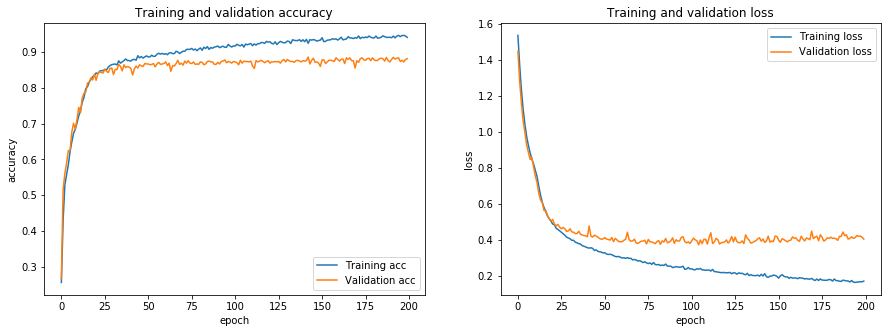

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()